

---


# MScFE 690 Capstone 
# Group 14
# Predicting Indian Stock Market Index Movement using Macroeconomic Data and Machine Learning


---


# Step 3: Modelling and Evaluation

Following Macroeconomic variables and Indexs are captured and analyzed for this paper are:

* GDP Growth rate
* Crude Oil
* Monetary Policy
* USD/INR Exchange rates
* US Global and Indian Market Index
* Industrial Production
* CPI

In this notebook, we will use LSTM machine learning alorightm to predict NSE Nifty Index monthly prices using macroeconomic variables.

In [90]:
# Imports
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score

In [101]:
# Read the input file and set Date as the index
input_data_df = pd.read_csv("indexs_and_macroeconomic_data.csv")
input_data_df.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
input_data_df = input_data_df.set_index('Date')
input_data_df

,NSE Adj Close,Dow Jones Adj Close,Norm GDP,Brent Crude Price,CPI,IIP,Central Bank Rates,USD INR Rate,FII Net Purchase or Sales,DII Net Purchase or Sales
Date,,,,,,,,,,
1996-05-01,1137.80,5575.220215,100.928058,19.319130,27.196636,34.956089,12.00,34.80,NaN,NaN
1996-06-01,1089.90,5643.180176,100.835625,18.577500,27.611219,34.513567,12.00,35.23,NaN,NaN
1996-07-01,1109.00,5729.979980,100.743785,19.714783,28.108718,34.114211,12.00,35.10,NaN,NaN
1996-08-01,1036.60,5594.750000,100.653025,20.605909,28.440385,34.920563,12.00,35.65,NaN,NaN
1996-09-01,1029.00,5616.209961,100.563376,23.081429,28.523301,34.590072,12.00,35.85,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-01-01,17354.05,36338.300781,99.574644,85.622381,137.830179,119.009911,4.25,74.39,-35493.59,31231.05
2022-02-01,17576.85,35405.238281,99.517528,94.267000,137.720003,117.988724,4.25,74.78,-41346.35,21928.40
2022-03-01,16793.90,33294.949219,99.423298,112.440000,138.821763,119.245588,4.25,75.79,-45720.07,42084.07


Dropping FII and DII data since we dont have data since 1996, we will utilize other macroeconomic indicator for this ML model. Dropped Norm GDP Factor also since we were not getting best results with that.

In [102]:
input_data_df = input_data_df.drop(columns=['FII Net Purchase or Sales','DII Net Purchase or Sales','Norm GDP'])
input_data_df

,NSE Adj Close,Dow Jones Adj Close,Brent Crude Price,CPI,IIP,Central Bank Rates,USD INR Rate
Date,,,,,,,
1996-05-01,1137.80,5575.220215,19.319130,27.196636,34.956089,12.00,34.80
1996-06-01,1089.90,5643.180176,18.577500,27.611219,34.513567,12.00,35.23
1996-07-01,1109.00,5729.979980,19.714783,28.108718,34.114211,12.00,35.10
1996-08-01,1036.60,5594.750000,20.605909,28.440385,34.920563,12.00,35.65
1996-09-01,1029.00,5616.209961,23.081429,28.523301,34.590072,12.00,35.85
...,...,...,...,...,...,...,...
2022-01-01,17354.05,36338.300781,85.622381,137.830179,119.009911,4.25,74.39
2022-02-01,17576.85,35405.238281,94.267000,137.720003,117.988724,4.25,74.78
2022-03-01,16793.90,33294.949219,112.440000,138.821763,119.245588,4.25,75.79


Method to convert the data point for t-1 time instance, this will convert all input variable(including the prediction value itself here Nifty Index price) for time t-1 instance and they will be used to predict y at time t.

In [103]:
# Convert series for supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Logic to normalize the data points

In [104]:
values = input_data_df.values
# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head)

<bound method NDFrame.head of      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.018766   0.000000   0.074208   0.000000   0.011073   1.000000   
2     0.015967   0.002209   0.068199   0.003607   0.006157   1.000000   
3     0.017084   0.005031   0.077414   0.007936   0.001721   1.000000   
4     0.012853   0.000635   0.084634   0.010822   0.010678   1.000000   
5     0.012409   0.001332   0.104690   0.011543   0.007007   1.000000   
..         ...        ...        ...        ...        ...        ...   
308   0.955429   0.924706   0.522732   0.965489   0.940100   0.205128   
309   0.966365   1.000000   0.611402   0.962613   0.944806   0.205128   
310   0.979384   0.969669   0.681441   0.961655   0.933462   0.205128   
311   0.933632   0.901071   0.828680   0.971241   0.947424   0.205128   
312   0.984854   0.950589   0.777764   0.987538   1.000000   0.205128   

     var7(t-1)   var1(t)  
1     0.000000  0.015967  
2     0.010317  0.017084  
3     0.0071

Divide the historic data into two parts one will be used to make ML model learn from the past events using the training data set (80% of data). Rest of the data will be used for testing (test data 20%).

In [105]:
# split into train and test sets
values = reframed.values
n_train = 0.8*values.shape[0]
train = values[:int(n_train), :]
test = values[int(n_train):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(249, 1, 7) (249,) (63, 1, 7) (63,)


In [106]:
# design network
model = Sequential()
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=23, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/60
11/11 - 3s - loss: 0.1247 - val_loss: 0.4910 - 3s/epoch - 252ms/step
Epoch 2/60
11/11 - 0s - loss: 0.0853 - val_loss: 0.3880 - 60ms/epoch - 5ms/step
Epoch 3/60
11/11 - 0s - loss: 0.0698 - val_loss: 0.3045 - 55ms/epoch - 5ms/step
Epoch 4/60
11/11 - 0s - loss: 0.0633 - val_loss: 0.2493 - 62ms/epoch - 6ms/step
Epoch 5/60
11/11 - 0s - loss: 0.0606 - val_loss: 0.2326 - 65ms/epoch - 6ms/step
Epoch 6/60
11/11 - 0s - loss: 0.0531 - val_loss: 0.2250 - 59ms/epoch - 5ms/step
Epoch 7/60
11/11 - 0s - loss: 0.0439 - val_loss: 0.2023 - 67ms/epoch - 6ms/step
Epoch 8/60
11/11 - 0s - loss: 0.0378 - val_loss: 0.1707 - 77ms/epoch - 7ms/step
Epoch 9/60
11/11 - 0s - loss: 0.0360 - val_loss: 0.1561 - 74ms/epoch - 7ms/step
Epoch 10/60
11/11 - 0s - loss: 0.0334 - val_loss: 0.1457 - 62ms/epoch - 6ms/step
Epoch 11/60
11/11 - 0s - loss: 0.0317 - val_loss: 0.1272 - 59ms/epoch - 5ms/step
Epoch 12/60
11/11 - 0s - loss: 0.0306 - val_loss: 0.1098 - 62ms/epoch - 6ms/step
Epoch 13/60
11/11 - 0s - loss: 0.0295

Running the prediction model and plotting it on the graph for better visualization.

2/2 [==============================] - 0s 8ms/step
Test RMSE: 843.506
R_Squared: 0.8977121719651175, Adjusted R_Squared: 0.8846937211243143, MSE: 843.5059744581761, Scatter Index: 0.06887493073688167




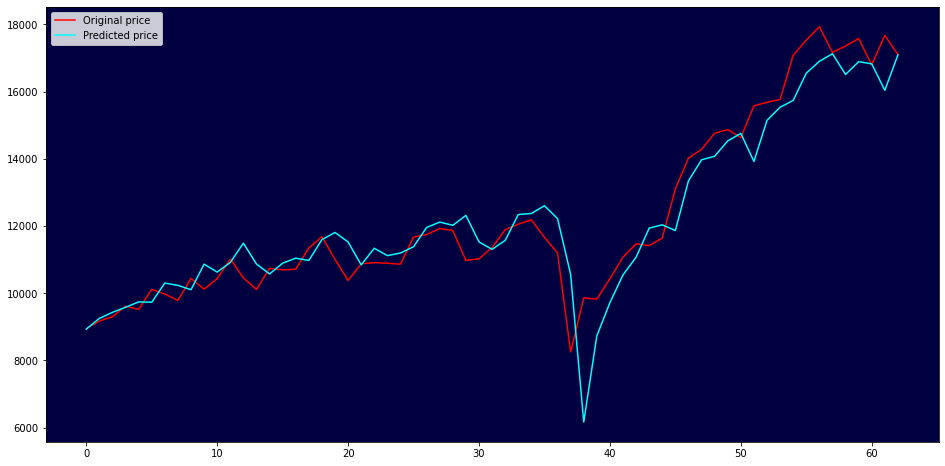

In [107]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Plot Prediction
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(inv_y, color='red', label='Original price')
plt.plot(inv_yhat, color='cyan', label='Predicted price')
plt.legend()
# calculate Error
R_2 = r2_score(inv_y, inv_yhat)
adjusted_r_squared = 1 - (1-R_2)*(len(inv_y)-1)/(len(inv_y) - test_X.shape[1]-1)
mse = mean_squared_error(inv_y, inv_yhat, squared=False)
scatter_index = (mse/inv_y.mean())
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(f"R_Squared: {R_2}, Adjusted R_Squared: {adjusted_r_squared}, " \
      f"MSE: {mse}, Scatter Index: {scatter_index}\n\n")

Summary:
We can see model is working fairly decent and is able to predict with decent scores.
The Accuracy of the model is defined by the R_Square statistic. The R_Square value is showing up a decent score of 0.8846937211243143, demostrating a decent fit on the data.
If we look at Scatter Index score it is coming under 7%.

Prediction could have been lot better if you could have more data, and considering India being developing nation we dont have dense information available. But we could say that model have given a decent performance and it can be more useful in future when would have more macroeconomic data available.